# Big data analysis using machine learning and probabilistic models 
# part A - 1D distributions

### General Instructions 
Follow the instructions below to analyze the data matrix “mm_gastru_small.h5ad”. You are free to use any package or software (in Python or R). As we are practicing here data analysis, which is always done under uncertainty, you will find that in many cases you need to make hard decisions on parameters/algorithms/visualization. This is OK. There is no single “correct” solution – a perfect project will be one that conveys understanding of the underlying data using the methodologies we studied in class.<br />
<br />
Describe your work in:<br />
A Jupyter notebook with explanations in markdown and comments.<br />
Alternatively, provide A written report (pdf) with concise description of what you find, including figures (strict limit on length is 6 pages – keep figures small..). As well as your “source” code (no need to have it documented, but put sections in it per figure you are generating.<br />
Please work alone. You are however free to discuss with fellow students regarding tools and analysis strategies. 


[Presentation slides](https://www.dropbox.com/scl/fi/n9p05lfywobb87z9m8u2v/aihub_scrna_ex.pptx?rlkey=4pow0181sr4wog0wasxv2xg34&dl=0)

#### A bit of biological context (for the curious and less biologically inclined) [tl;dr measures the expression of genes in cells]
Single-cell transcriptomics examines the gene expression level of individual cells in a given population by simultaneously measuring the RNA concentration (conventionally only messenger RNA (mRNA)) of hundreds to thousands of genes. Single-cell transcriptomics makes it possible to unravel heterogeneous cell populations, reconstruct cellular developmental pathways, and model transcriptional dynamics. <br>
Typical single-cell RNA-Seq workflow: Single cells are isolated from a sample into either wells or droplets, cDNA libraries are generated and amplified, libraries are sequenced, and expression matrices are generated for downstream analyses like cell type identification.
![Single Cell RNA Sequencing (scRNA-seq)](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/RNA-Seq_workflow-5.pdf/page1-800px-RNA-Seq_workflow-5.pdf.jpg)


#### A note on sparse matrices [tl;dr matrices where most elements are zero]
A sparse matrix or sparse array is a matrix in which most of the elements are zero. There is no strict definition regarding the proportion of zero-value elements for a matrix to qualify as sparse but a common criterion is that the number of non-zero elements is roughly equal to the number of rows or columns. By contrast, if most of the elements are non-zero, the matrix is considered dense. The number of zero-valued elements divided by the total number of elements (e.g., m × n for an m × n matrix) is sometimes referred to as the sparsity of the matrix. <br>
#### Storing a sparse matrix [tl;dr sparse matrices are usually found in dedicated data formats]
A matrix is typically stored as a two-dimensional array. Each entry in the array represents an element ai,j of the matrix and is accessed by the two indices i and j. Conventionally, i is the row index, numbered from top to bottom, and j is the column index, numbered from left to right. For an m × n matrix, the amount of memory required to store the matrix in this format is proportional to m × n (disregarding the fact that the dimensions of the matrix also need to be stored).<br>
<br>
In the case of a sparse matrix, substantial memory requirement reductions can be realized by storing only the non-zero entries. Depending on the number and distribution of the non-zero entries, different data structures can be used and yield huge savings in memory when compared to the basic approach. The trade-off is that accessing the individual elements becomes more complex and additional structures are needed to be able to recover the original matrix unambiguously. <br>

### Description of the data
Our input is a table, depicting the number of molecules attributed to each cell and each gene. The cells are also annotated with some grouping and additional metadata. Here we sample cells from mouse embryos at gestation days 6 to 7.5, when the embryos start gastrulating - transforming from a uniform mass of cells to many different cell types with specific expertise.

Raw data matrix – is a sparse matrix of integers. It indicates the number of sampled RNA molecules per gene (variables / columns) in a set of cells (observables / rows). The sparseness comes from the fact that the total number of genes in the genome is big (\~30,000), but the total number of RNAs is not much bigger (\~100,000), so RNA from most genes are not present in most cells. In addition, the experiment that generate the data samples only a subset of the RNA molecules in the cell (1,000-10,000).<br />
The data is provided in the anndata format, where the matrix itself is available in the field “X” (X is the actual name of the field). Additional metadata for the rows/cols is available under obs/var fields. Note, modified X versions can be placed in “layers”.<br />
![Data structure schematic (Anndata)](anndata_schema.png)
Data structure schematic (Anndata)

### In this stage you'll explore sparse data matrix of samples (cells) over features (genes). 
    Your overall goal is to find "interesting" features. 
    You will normalize samples using simple strategies and explore the distribution of features of samples

### Imports

In [126]:
import anndata as ad
import scanpy as sc
#import metacells as mc
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as stats
import matplotlib.pylab as plt
import os
import seaborn as sns
%matplotlib inline

In [128]:
#Get current working directory:
cwd = os.getcwd()

# if cwd is not 'root/guyilan/masetr/aihub/Tutorials/AIhub/ex-scrna' then change it
if cwd != '/home/labs/antebilab/guyilan/master/aihub/Tutorials/AIhub/ex-scrna':
    os.chdir('/home/labs/antebilab/guyilan/master/aihub/Tutorials/AIhub/ex-scrna')
    cwd = os.getcwd()
    print('Current working directory is:', cwd)

#### Download the data
<span style="color: red;">
Download data (only when starting the tutorial for the first time):</span>

In [ ]:
#!wget https://embexe.s3.eu-west-1.amazonaws.com/mm_gastru_small.h5ad

--2024-11-18 14:11:04--  https://embexe.s3.eu-west-1.amazonaws.com/mm_gastru_small.h5ad
Resolving embexe.s3.eu-west-1.amazonaws.com (embexe.s3.eu-west-1.amazonaws.com)... 3.5.65.30, 3.5.69.128, 3.5.66.164, ...
Connecting to embexe.s3.eu-west-1.amazonaws.com (embexe.s3.eu-west-1.amazonaws.com)|3.5.65.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228444248 (218M) [binary/octet-stream]
Saving to: ‘mm_gastru_small.h5ad’

mm_gastru_small.h5a 100%[===================>] 217.86M  34.8MB/s    in 6.9s    

2024-11-18 14:11:12 (31.4 MB/s) - ‘mm_gastru_small.h5ad’ saved [228444248/228444248]



# 1D distributions

## Tasks

1.	Read the raw data matrix using the anndata package (“read_h5ad” function):

    a)	How many cells are there? How many genes? (hint: how many rows? columns?)
    
    b)	What is the sparsity of this matrix?
    
    c)	Plot a histogram of the cell (rows / obs) sums   
            try using log
            
    i.e. - total sum of genes per cell, and limit the max range in the plot.

In [146]:
#Read the data:
adata = ad.read_h5ad("mm_gastru_small.h5ad")

#calculate the number of cells and genes:
n_cells = adata.n_obs
n_genes = adata.n_vars
print(f"Number of cells: {n_cells}")
print(f"Number of genes: {n_genes}")

not_zeros = np.sum(adata.X != 0)

total_elements = n_cells * n_genes

frac_zeros = (total_elements - not_zeros) / total_elements

print(f"Fraction of zero values: {frac_zeros:.4f}")

Number of cells: 14976
Number of genes: 19701
Fraction of zero values: 0.9057


1a. The data contains 14975 cells and 19701 genes 
<br>
1b. Sparsity - The number of zero-valued elements divided by the total number of elements. sparsity of the matrix is 0.9057

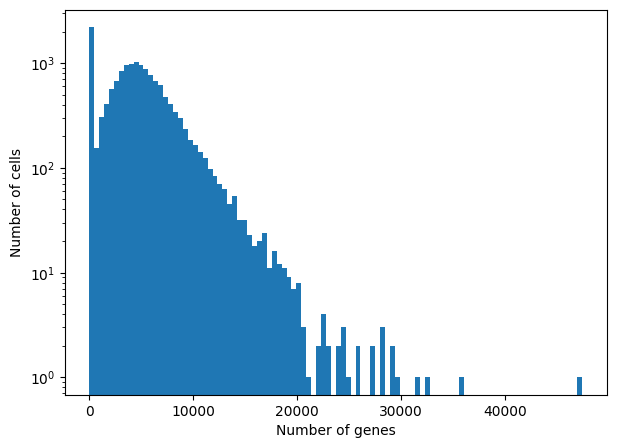

In [147]:
#1c plotting histograms of the number of genes and counts per cell
total_genes = np.sum(adata.X , axis=1)

#check dimensions:
if len(total_genes) != n_cells:
    print('Error: dimensions do not match')

plt.figure(figsize=(7, 5))
genes_hist = plt.hist(total_genes, bins=100)
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.yscale('log')
plt.show()

In [154]:
np.sum(adata.X , axis=1)

matrix([[2487.],
        [5602.],
        [1903.],
        ...,
        [  53.],
        [  39.],
        [  18.]], dtype=float32)

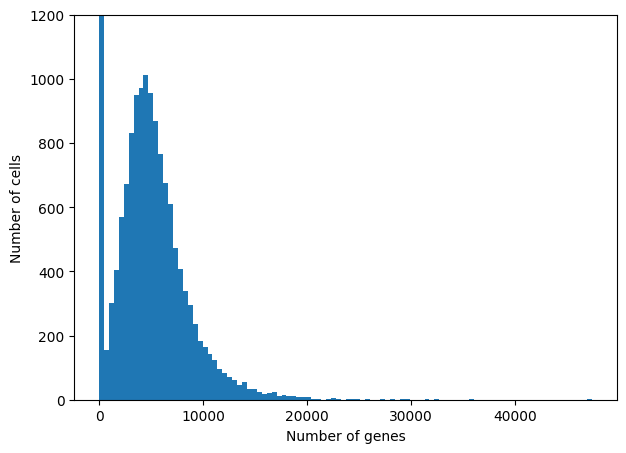

In [148]:
plt.figure(figsize=(7, 5))
genes_hist = plt.hist(total_genes, bins=100)
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.ylim(0,1200)

plt.show()

2.	Working on the raw data matrix, study the statistical distributions of total cells (rows) sums. 
    Is it a normal distribution? perhaps log-normal? two overlaid distributions?<br>

<Axes: ylabel='Density'>

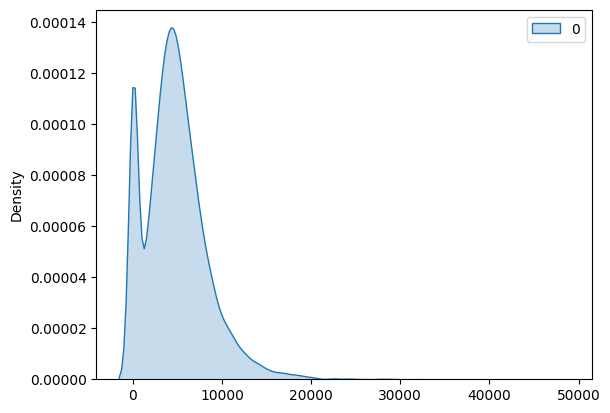

In [142]:
#plot kde of total genes:
sns.kdeplot(total_genes, fill=True)

* Looking at the KDE plot we can see one distributions with another small peak at the origin.
<br>
* The peak is from many cells containing low numbers of genes, which are probably the product of technical noise or dead cells. 
<br>
* It can be considered as another ditribution which represent the low read / low genes cells, but it is not relevant for our analysis.
<br>
* The main distribution does not look like a normal distribution. It looks more like negatibe binomial distribution which is often used to as a model for gene expression data

In [169]:
#Using ks test to check if the data is normally distributed:
ks_stat, ks_pval = stats.kstest(total_genes, 'norm')

print(f"KS test statistic: {ks_stat[0]:.4f}")
print(f"KS test p-value: {ks_pval[0]:.4f}")


KS test statistic: 0.9997
KS test p-value: 0.0000


KS test statistic: 0.9833
KS test p-value: 0.0000


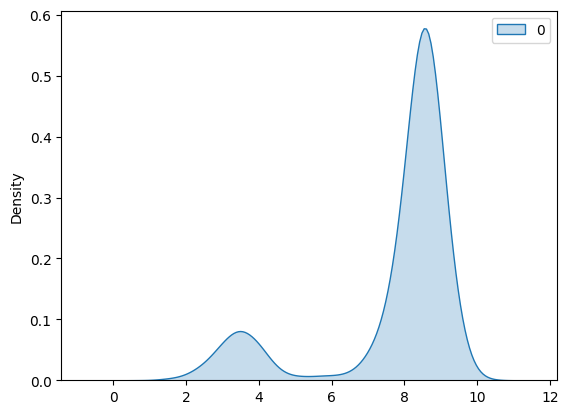

In [171]:
log_total_genes = np.log(total_genes)

#Using ks test to check if the data is normally distributed:
ks_stat, ks_pval = stats.kstest(log_total_genes, 'norm')

print(f"KS test statistic: {ks_stat[0]:.4f}")
print(f"KS test p-value: {ks_pval[0]:.4f}")

#plot kde of log total genes:
sns.kdeplot(log_total_genes, fill=True)

plt.show()

3.	Suggest a minimal sum for the cells (rows). Under-sampled cells typically report empty samples. Remove them from the dataset.

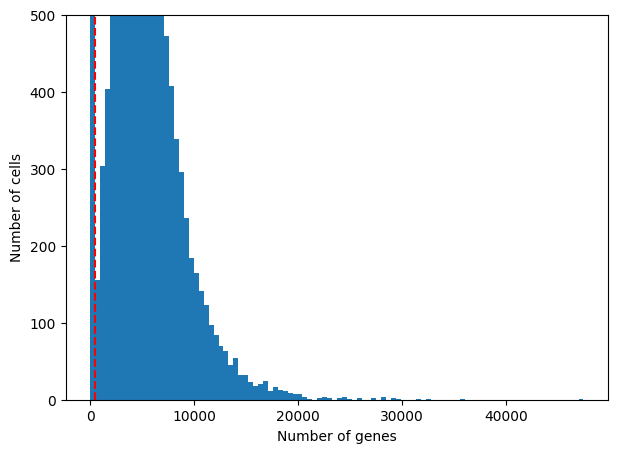

In [172]:
plt.figure(figsize=(7, 5))
genes_hist = plt.hist(total_genes, bins=100)
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.ylim(0,500)
#add a vertical line at 500:
plt.axvline(x=500, color='r', linestyle='--')

plt.show()

Removing all cells with under 500 genes expressed will remove the entire distribution of unuseable cells:

Number of genes filtered: 2210


<Axes: ylabel='Density'>

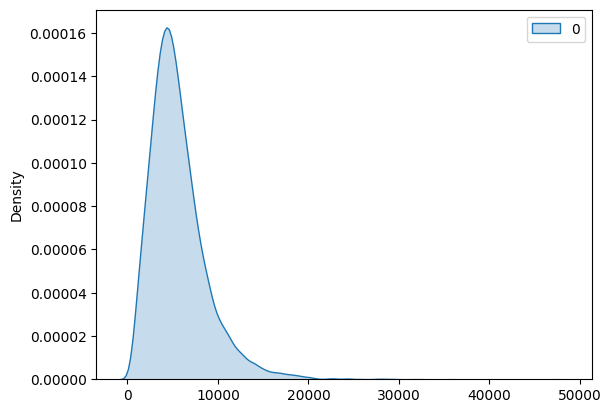

In [177]:
total_genes_filt = total_genes[total_genes > 500]

#how many cells have less than 500 genes?
n_cells_filt = len(total_genes) - len(total_genes_filt.reshape(-1, 1))
print(f"Number of genes filtered: {n_cells_filt}")

total_genes_filt = total_genes_filt.reshape(-1, 1)

sns.kdeplot(total_genes_filt, fill=True)

We filtered 2272 cells fro mthe raw data.
<br>
We are left with a single distribution of cells.

4.	Working on the cleaned data matrix, study the statistical distributions of total genes (columns) sums.

In [57]:
data = adata[total_genes > 500].X

#print shaoe of data:
print(data.shape)

(12704, 19701)


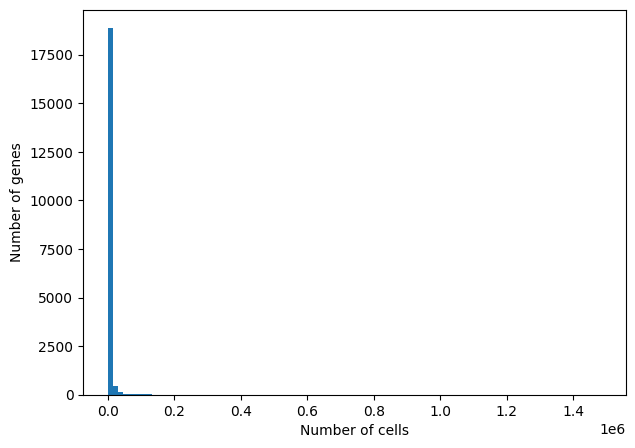

In [178]:
#Checking how many cells are expressing each gene:

total_cells = np.sum(data,axis=0)
total_cells = total_cells.reshape(-1, 1)

#check dimensions:
if len(total_cells) != n_genes:
    print('Error: dimensions do not match')

plt.figure(figsize=(7, 5))
cells_hist = plt.hist(total_cells, bins=100)
plt.xlabel('Number of cells')
plt.ylabel('Number of genes')
plt.show()

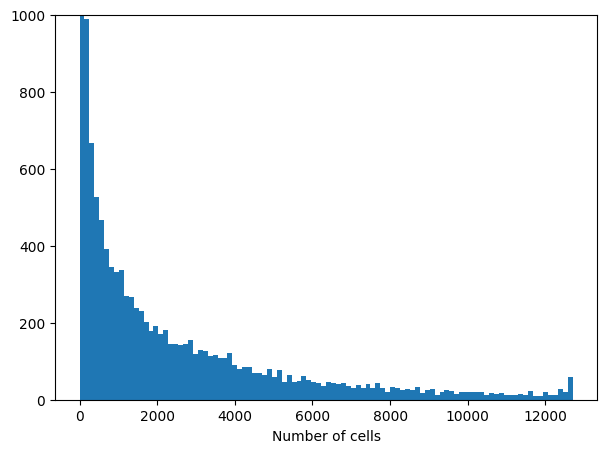

In [59]:
plt.figure(figsize=(7, 5))
cells_hist = plt.hist(total_cells, bins=100)
plt.xlabel('Number of cells')
plt.ylim(0,1000)

plt.show()


<Axes: ylabel='Density'>

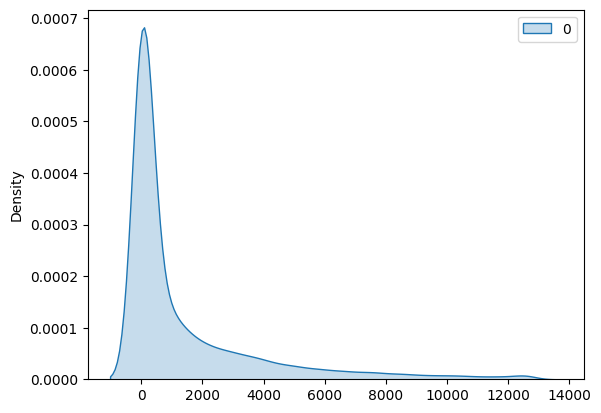

In [62]:
sns.kdeplot(total_cells, fill=True)

The distribution of the the total cells 

5. Which features show high variance? report top 10 genes

6. normalize samples by their coverage

5.	The down-sampled matrix – is the raw data matrix in which each column (cell) where sufficient RNA count is normalized probabilistically. For example, sampling exactly 1000 RNAs from the cell. This is the matrix you should generally work with. Down-sample the matrix and perform a similar analysis on the distribution of total gene sums.
  
    Use either scanpy or metacells packages for downsampling .
    

7. Plot standard deviation vs. Mean on the two normed matrices

8. Which features (genes) show high variance after normalization? report the top 10 genes

    Option: read about 2 of the genes

    (Before: bad uninteresting genes, After: relevant feature genes)

9. Finally study the distribution of RNA counts across cells in individual columns – should it be modeled as a continuous variable? And if discrete, is it following some simple distribution? Support your analysis with figures. Bonus – support your analysis by statistical tests.

Extra: are there ways to bring all the genes (columns / vars) into a similar distribution? Provide a scheme (no need to implement) or discuss why this is not advisable or possible.<br />

Note: A simple and natural way to interpret the experiment that produced this data is as independent sampling of gene copies from a cell. Following that, it is tempting to think of rows (cells / obs) as multinomial samples (or to approximate a single gene count as a binomial variable).<br />